In [2]:
import pyexasol
import pandas as pd
import boto3
import time
import io
import numpy as np
from matplotlib import pyplot as plt

class QueryAthena:

    def __init__(self, query, database):
        self.database = 'btb-serving'
        self.folder = 'api/'
        self.bucket = 'btb-athena-query-results'
        self.s3_input = 's3://' + self.bucket + '/my_folder_input'
        self.s3_output =  's3://' + self.bucket + '/' + self.folder
        self.region_name = 'eu-central-1'
        self.query = query
        self.access_key = '***'
        self.secret_key = '***'

    def load_conf(self, q):
        
        try:
            self.client = boto3.client('athena', region_name = self.region_name, aws_access_key_id=self.access_key,
                                  aws_secret_access_key=self.secret_key)
            
            response = self.client.start_query_execution(
                QueryString = q,
                    QueryExecutionContext={
                    'Database': self.database
                    },
                    ResultConfiguration={
                    'OutputLocation': self.s3_output,
                    }
            )
            self.filename = response['QueryExecutionId']
            print('Execution ID: ' + response['QueryExecutionId'])

        except Exception as e:
            print(e)
        return response                

    def run_query(self):
        queries = [self.query]
        for q in queries:
            res = self.load_conf(q)
        try:              
            query_status = None
            while query_status == 'QUEUED' or query_status == 'RUNNING' or query_status is None:
                query_status = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']['State']
                query_status2 = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']
                print(query_status2)
                if query_status == 'FAILED' or query_status == 'CANCELLED':
                    raise Exception('Athena query with the string "{}" failed or was cancelled'.format(self.query))
                time.sleep(0.2)
            print('Query "{}" finished.'.format(self.query))

            df = self.obtain_data()
            return df

        except Exception as e:
            print(e)      

    def obtain_data(self):
        try:
            self.resource = boto3.resource('s3', 
                                  region_name = self.region_name,
                                  aws_access_key_id=self.access_key,
                                  aws_secret_access_key=self.secret_key)
                                  
            print(self.bucket)
            print(self.folder)
            print(self.filename)
            
            # S3 Object
            res_obj = self.resource.Object(bucket_name=self.bucket, key=self.folder + self.filename + '.csv')
            response = res_obj.get()
            
            return pd.read_csv(io.BytesIO(response['Body'].read()), encoding='utf8')   
        except Exception as e:
            print(e) 
            
            
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'])
    #Add chart labels
    plt.title(model_type)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## Correlation

Execution ID: e91381bc-1e4b-4cab-a6f6-aed3076f6cab
{'State': 'QUEUED', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal())}
{'State': 'SUCCEEDED', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 5, 194000, tzinfo=tzlocal()), 'CompletionDateTime': datetime.datetime(2022, 7, 25, 11, 8, 6, 516000, tzinfo=tzlocal())}
Query "
select
    round(home_ppda_for_ema,1) home_xg_against_ema,
    avg(full_time_away_goals)
from
    "ml_poisson_features"
where
    feature_type = 'EMA5 HA'
    and full_time_home_goals 

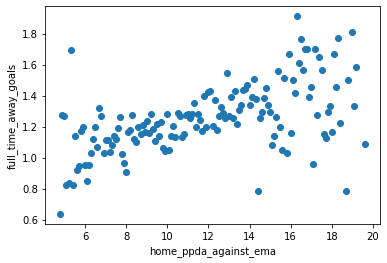

,home_xg_against_ema,_col1
home_xg_against_ema,1.000000,0.557732
_col1,0.557732,1.000000


In [5]:
v_sql = """
select
    round(home_ppda_for_ema,1) home_xg_against_ema,
    avg(full_time_away_goals)
from
    "ml_poisson_features"
where
    feature_type = 'EMA5 HA'
    and full_time_home_goals is not null
    --and home_xg_against_ema < 30
group by 1
having count(*) > 10
    """


qa = QueryAthena(query=v_sql, database='btb-serving')
df_data = qa.run_query()
  
#print(df_data.head)


x = df_data.iloc[:,0]
y = df_data.iloc[:,1]

plt.scatter(x, y) 
plt.xlabel("home_ppda_against_ema")
plt.ylabel("full_time_away_goals")
plt.show()

df_data.corr(method ='pearson')

## Feature importance

Execution ID: d3eff883-0425-42fb-96d1-c6971a568d71
{'State': 'QUEUED', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 11, 15, 53, 37, 235000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': dat

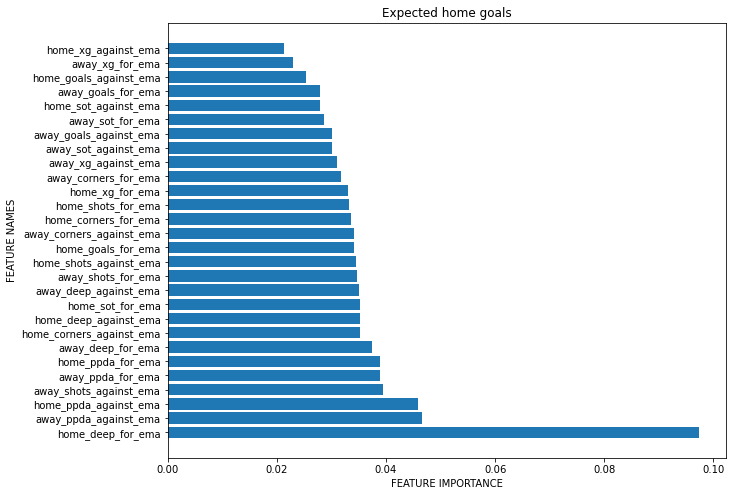

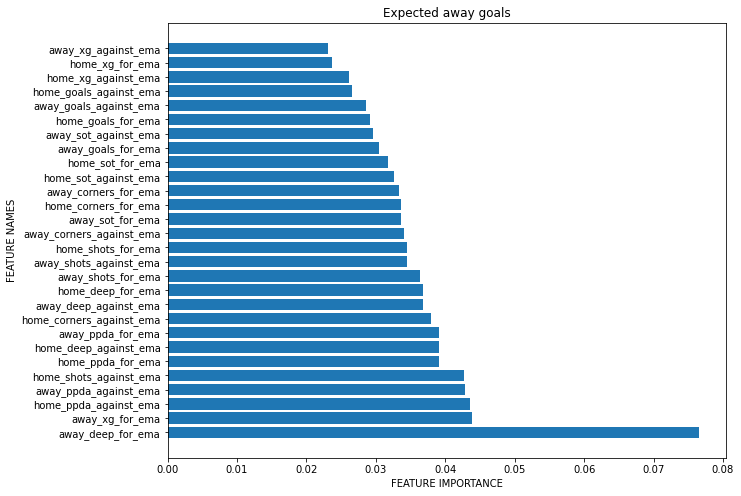

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


v_sql = """
select
    round(home_goals_for_ema,1)            home_goals_for_ema,
    round(home_goals_against_ema,1)        home_goals_against_ema,
    round(away_goals_for_ema,1)            away_goals_for_ema,
    round(away_goals_against_ema,1)        away_goals_against_ema,
    round(home_xg_for_ema,1)               home_xg_for_ema,
    round(home_xg_against_ema,1)           home_xg_against_ema,
    round(away_xg_for_ema,1)               away_xg_for_ema,
    round(away_xg_against_ema,1)           away_xg_against_ema,
    round(home_shots_for_ema,1)               home_shots_for_ema,
    round(home_shots_against_ema,1)           home_shots_against_ema,
    round(away_shots_for_ema,1)               away_shots_for_ema,
    round(away_shots_against_ema,1)           away_shots_against_ema,
    round(home_sot_for_ema,1)               home_sot_for_ema,
    round(home_sot_against_ema,1)           home_sot_against_ema,
    round(away_sot_for_ema,1)               away_sot_for_ema,
    round(away_sot_against_ema,1)           away_sot_against_ema,
    round(home_corners_for_ema,1)               home_corners_for_ema,
    round(home_corners_against_ema,1)           home_corners_against_ema,
    round(away_corners_for_ema,1)               away_corners_for_ema,
    round(away_corners_against_ema,1)           away_corners_against_ema,
    round(home_deep_for_ema,1)               home_deep_for_ema,
    round(home_deep_against_ema,1)           home_deep_against_ema,
    round(away_deep_for_ema,1)               away_deep_for_ema,
    round(away_deep_against_ema,1)           away_deep_against_ema,
    round(home_ppda_for_ema,1)               home_ppda_for_ema,
    round(home_ppda_against_ema,1)           home_ppda_against_ema,
    round(away_ppda_for_ema,1)               away_ppda_for_ema,
    round(away_ppda_against_ema,1)           away_ppda_against_ema,
    avg(full_time_home_goals)               full_time_home_goals,
    avg(full_time_away_goals)               full_time_home_goals
from
    "ml_poisson_features"
where
    feature_type = 'EMA5 HA'
    and full_time_home_goals is not null
    and home_shots_for_ema is not null
    and away_shots_against_ema is not null
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
    """


qa = QueryAthena(query=v_sql, database='btb-serving')
df_data = qa.run_query()
  
#print(df_data.head)

pd_feature = df_data.iloc[:,0:28]

pd_class_home = df_data.iloc[:,28]
pd_class_away = df_data.iloc[:,29]

#print(pd_feature.head)
#print(pd_class.head)

model_home = RandomForestRegressor()
model_home.fit(pd_feature,pd_class_home) 

model_away = RandomForestRegressor()
model_away.fit(pd_feature,pd_class_away) 


plot_feature_importance(model_home.feature_importances_, pd_feature.columns, 'Expected home goals')

plot_feature_importance(model_away.feature_importances_, pd_feature.columns, 'Expected away goals')

Execution ID: 27477c0b-dda1-4d02-aafb-3f01f0607f59
{'State': 'QUEUED', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 11, 18, 792000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': dat

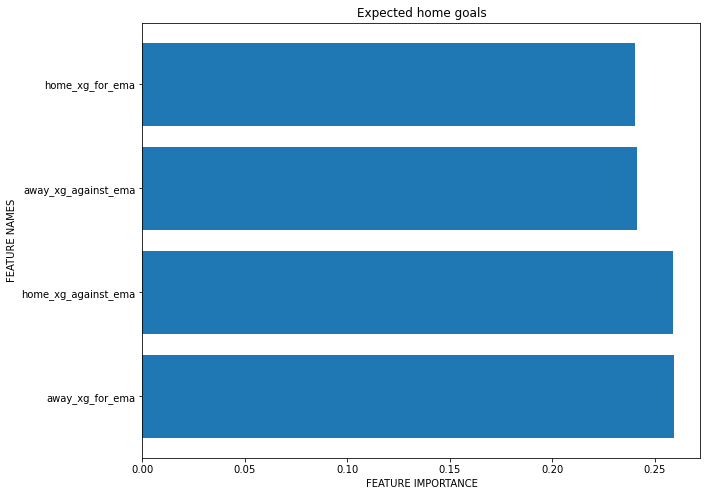

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


v_sql = """
select
    round(home_xg_for_ema,1)               home_xg_for_ema,    
    round(home_xg_against_ema,1)               home_xg_against_ema,    
    round(away_xg_for_ema,1)           away_xg_for_ema,    
    round(away_xg_against_ema,1)           away_xg_against_ema,    
    full_time_home_goals                   full_time_home_goals
from
    "ml_poisson_features"
where
    feature_type = 'EMA5 HA'
    and full_time_home_goals is not null
    and home_shots_for_ema is not null
    and away_shots_against_ema is not null
    """


qa = QueryAthena(query=v_sql, database='btb-serving')
df_data = qa.run_query()
  
#print(df_data.head)

pd_feature = df_data.iloc[:,:4]

pd_class_home = df_data.iloc[:,4]

#print(pd_feature.head)
#print(pd_class.head)

model_home = RandomForestRegressor()
model_home.fit(pd_feature,pd_class_home) 


plot_feature_importance(model_home.feature_importances_, pd_feature.columns, 'Expected home goals')
